In [3]:
import zipfile
import os
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
%matplotlib inline

In [4]:
from google.colab import files
uploaded = files.upload()


Saving SpamData.zip to SpamData.zip


In [5]:
zip_file = 'SpamData.zip'
unzip_dir = '/content/DataExtracted'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)


In [ ]:
import os
current_directory = os.getcwd()
print("Current working directory:", current_directory)

**Constants**

In [98]:
EXAMPLE_FILE = 'DataExtracted/SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'DataExtracted/SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'DataExtracted/SpamData/01_Processing/word-by-id.csv'


In [7]:
stream = open(EXAMPLE_FILE, encoding='utf-8')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [8]:
stream = open(EXAMPLE_FILE, encoding='utf-8')
is_body = False
lines = []

for line in stream:
  if is_body:
    lines.append(line)
  elif line == '\n':
    is_body = True

stream.close()
email_body = '\n'.join(lines)

print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

**Generator Functions**

In [9]:
def generate_squares(N):
  for my_number in range(N):
    yield my_number ** 2

In [10]:
for i in generate_squares(5):
  print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

**Email body extraction**

In [11]:
def email_body_generator(path):

  for root, dirnames, filenames in walk(path):
    for file_name in filenames:

      filepath = join(root, file_name)
      stream = open(filepath, encoding='latin-1')
      is_body = False
      lines = []

      for line in stream:
        if is_body:
          lines.append(line)
        elif line == '\n':
          is_body = True

      stream.close()
      email_body = '\n'.join(lines)

      yield file_name, email_body

In [14]:
def df_from_directory(path,classification):
  rows = []
  row_names = []

  for file_name, email_body in email_body_generator(path):
    rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
    row_names.append(file_name)


  return pd.DataFrame(rows, index=row_names)

In [15]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = pd.concat([spam_emails, df_from_directory(SPAM_2_PATH, 1)])
spam_emails.head()

,MESSAGE,CATEGORY
00465.ca5d79d0e5dadee322c117789196ebb4,"Mr.Vincent Nnaji,\n\n Standard Trust Bank Ltd,...",1
00441.77768298934252b2fa200e7d9482993b,"<html>\n\n<body>\n\n<p align=""center""><a href=...",1
00173.e10eb62e2c7808674c43d6a5e9e08a1c,"<html>\n\n<body bgColor=""#CCCCCC"" topmargin=1 ...",1
00445.94d3ccfafc541255ff46625091d333e4,Hi -\n\n\n\n( http://club.4tfox.com )\n\n\n\nY...,1
00330.c5f7346dec1e6fe6ed324d8e78a2b46e,This is a Multipart MIME message. Since your m...,1


In [16]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, 0)
ham_emails = pd.concat([ham_emails, df_from_directory(EASY_NONSPAM_2_PATH, 0)])
ham_emails.shape

(3901, 2)

In [17]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire DataFrame is:', data.shape)
data.head()

Shape of entire DataFrame is: (5799, 2)


,MESSAGE,CATEGORY
00465.ca5d79d0e5dadee322c117789196ebb4,"Mr.Vincent Nnaji,\n\n Standard Trust Bank Ltd,...",1
00441.77768298934252b2fa200e7d9482993b,"<html>\n\n<body>\n\n<p align=""center""><a href=...",1
00173.e10eb62e2c7808674c43d6a5e9e08a1c,"<html>\n\n<body bgColor=""#CCCCCC"" topmargin=1 ...",1
00445.94d3ccfafc541255ff46625091d333e4,Hi -\n\n\n\n( http://club.4tfox.com )\n\n\n\nY...,1
00330.c5f7346dec1e6fe6ed324d8e78a2b46e,This is a Multipart MIME message. Since your m...,1


In [18]:
data.tail()

,MESSAGE,CATEGORY
00911.91dd363a1ba091de446dd40a24816ab3,"On Fri, 26 Jul 2002, Ian Andrew Bell wrote:\n\...",0
01090.9c92673e26cabc5a37ac3e2b1b2bf8df,\n\n\n\nJohn Hall\n\n13464 95th Ave NE\n\nKirk...,0
00664.28f4cb9fad800d0c7175d3a67e6c6458,"Key concepts: Tokyo, urban overheating,\n\ncl...",0
00715.c11e77af45a2debe41aed46b2be09d59,\n\nMusic school jokes --\n\n\n\nAmerican cond...,0
00492.bc9e8dcbe986afe7ed1f38e988f43c8b,"As list administrator, your authorization is r...",0


**Data Cleaning: Checking for missing values**

In [19]:
#Check if any message bodies are null
#data.MESSAGE
#second option
data['MESSAGE'].isnull().values.any()


False

In [20]:
#check if there are empty emails(string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [21]:
(data.MESSAGE.str.len() == 0).sum()

3

In [22]:
data.MESSAGE.isnull().sum()

0

**Locate empty emails**

In [23]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [24]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [25]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

**Remove System File Entries from Dataframe**

In [26]:
data.drop(['cmds'], inplace=True)


In [27]:
data.shape

(5796, 2)

**Add Document Ids to track emails in dataset**

In [28]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids


In [29]:
data.DOC_ID

,DOC_ID
00465.ca5d79d0e5dadee322c117789196ebb4,0
00441.77768298934252b2fa200e7d9482993b,1
00173.e10eb62e2c7808674c43d6a5e9e08a1c,2
00445.94d3ccfafc541255ff46625091d333e4,3
00330.c5f7346dec1e6fe6ed324d8e78a2b46e,4
...,...
00911.91dd363a1ba091de446dd40a24816ab3,5791
01090.9c92673e26cabc5a37ac3e2b1b2bf8df,5792
00664.28f4cb9fad800d0c7175d3a67e6c6458,5793
00715.c11e77af45a2debe41aed46b2be09d59,5794


In [30]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"Mr.Vincent Nnaji,\n\n Standard Trust Bank Ltd,...",1,00465.ca5d79d0e5dadee322c117789196ebb4
1,"<html>\n\n<body>\n\n<p align=""center""><a href=...",1,00441.77768298934252b2fa200e7d9482993b
2,"<html>\n\n<body bgColor=""#CCCCCC"" topmargin=1 ...",1,00173.e10eb62e2c7808674c43d6a5e9e08a1c
3,Hi -\n\n\n\n( http://club.4tfox.com )\n\n\n\nY...,1,00445.94d3ccfafc541255ff46625091d333e4
4,This is a Multipart MIME message. Since your m...,1,00330.c5f7346dec1e6fe6ed324d8e78a2b46e


In [31]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,"On Fri, 26 Jul 2002, Ian Andrew Bell wrote:\n\...",0,00911.91dd363a1ba091de446dd40a24816ab3
5792,\n\n\n\nJohn Hall\n\n13464 95th Ave NE\n\nKirk...,0,01090.9c92673e26cabc5a37ac3e2b1b2bf8df
5793,"Key concepts: Tokyo, urban overheating,\n\ncl...",0,00664.28f4cb9fad800d0c7175d3a67e6c6458
5794,\n\nMusic school jokes --\n\n\n\nAmerican cond...,0,00715.c11e77af45a2debe41aed46b2be09d59
5795,"As list administrator, your authorization is r...",0,00492.bc9e8dcbe986afe7ed1f38e988f43c8b


**Save to file using Pandas**

In [32]:
data.to_json(DATA_JSON_FILE)

**Number of spam messages visualised**

In [33]:
data.CATEGORY.value_counts()

,count
CATEGORY,
0,3900
1,1896


In [34]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]
print('Amount of spam messages:', amount_of_spam)
print('Amount of ham messages:', amount_of_ham)

Amount of spam messages: 1896
Amount of ham messages: 3900


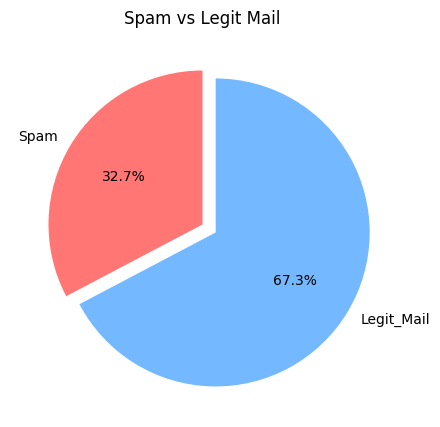

In [35]:
category_names = ['Spam', 'Legit_Mail']
sizes = [amount_of_spam, amount_of_ham]

custom_colors = ['#ff7675','#74b9ff']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, explode=[0, 0.1])
plt.title('Spam vs Legit Mail')
plt.show()

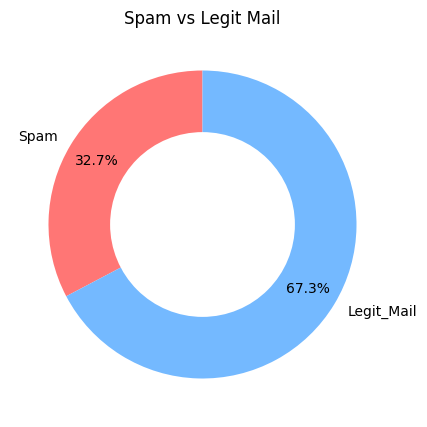

In [36]:
category_names = ['Spam', 'Legit_Mail']
sizes = [amount_of_spam, amount_of_ham]

custom_colors = ['#ff7675','#74b9ff']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, pctdistance=0.8)

#draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Spam vs Legit Mail')
plt.show()

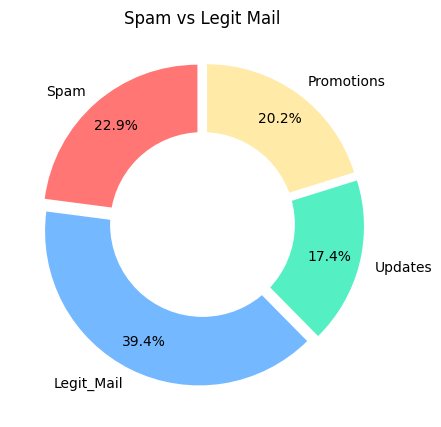

In [37]:
category_names = ['Spam', 'Legit_Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
offset = [0.05, 0.05, 0.05, 0.05]

custom_colors = ['#ff7675','#74b9ff', '#55efc4', '#ffeaa7']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, pctdistance=0.8, explode=offset)

#draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Spam vs Legit Mail')
plt.show()

# **Natural Language Processing**
**Text Pre-Processing**

In [38]:
msg = 'All work and no play makes Jack a dull boy'
msg.lower()

'all work and no play makes jack a dull boy'

**Download the NLTK Resources(Tokenizer & Stopwords)**

In [39]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [41]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Tokenising**

In [42]:
msg = 'All work and no play makes Jack a dull boy'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

**Removing stop words**

In [43]:
stop_words = set(stopwords.words('english'))

In [44]:
if 'this' in stop_words:
  print('True')
else:
  print('Nope.Not in here')

True


In [45]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question.'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
  if word not in stop_words:
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy.to', 'question', '.']


**Word Stems and Stemming**

In [46]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question. \
Nobody expects Spanish Inquisition'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
  if word not in stop_words:
    stemmed_word = stemmer.stem(word)
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy.to', 'question', '.', 'nobody', 'expects', 'spanish', 'inquisition']


In [47]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question.??? \
Nobody expects Spanish Inquisition'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
  if word not in stop_words and word.isalpha():
    stemmed_word = stemmer.stem(word)
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'nobody', 'expects', 'spanish', 'inquisition']


**Removing HTML tags from emails**

In [48]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

<html>
 <body bgcolor="#CCCCCC" oncontextmenu="return false" ondragstart="return false" onmouseover="window.status=''; return true" onselectstart="return false" topmargin="1">
  Hello, zzzz@neilgarner.com
  <br/>
  <br/>
  As se
  <!--5-->
  en on NB
  <!--D-->
  C, CBS, and CN
  <!--H-->
  N, and even Opr
  <!--D-->
  ah!  The health
  <br/>
  discove
  <!--F-->
  ry that actually revers
  <!--D-->
  es aging while burning fat,
  <br/>
  with
  <!--boy-->
  out dieti
  <!--D-->
  ng or exerc
  <!--F-->
  ise!  This pro
  <!--A-->
  ven discovery has even
  <br/>
  been report
  <!--zzzz-->
  ed on by the Ne
  <!--test-->
  w Engl
  <!-- -->
  and Jour
  <!--F-->
  nal of Medi
  <!--F-->
  cine.
  <br/>
  For
  <!--zzzz-->
  get aging and d
  <!-- -->
  ieting forever!  And it's Gua
  <!--S-->
  ranteed!
  <br/>
  <br/>
  <br/>
  * Red
  <!--lo-->
  uce body fat and build lean muscle WIT
  <!--zzzz-->
  HOUT EXERCISE!
  <br/>
  * Enha
  <!--zzzz-->
  ce se
  <!--la-->
  xual perf
  <!-

In [49]:
soup.get_text()

"\n\n\nHello, zzzz@neilgarner.com\n\n\nAs seen on NBC, CBS, and CNN, and even Oprah!  The health\n\ndiscovery that actually reverses aging while burning fat,\n\nwithout dieting or exercise!  This proven discovery has even\n\nbeen reported on by the New England Journal of Medicine.\n\nForget aging and dieting forever!  And it's Guaranteed!\n\n\n* Reduce body fat and build lean muscle WITHOUT EXERCISE!\n\n* Enhace sexual performance\n\n* Remove wrinkles and cellulite\n\n* Lower blood pressure and improve cholesterol profile\n\n* Improve sleep, vision and memory\n\n* Restore hair color and growth\n\n* Strengthen the immune system\n\n* Increase energy and cardiac output\n\n* Turn back your body's biological time clock 10-20 years\n\nin 6 months of usage !!!\nFOR FREE INFORMATION AND GET FREE \n\n1 MONTH SUPPLY OF HGH CLICK HERE\n\nYou are receiving this email as a subscriber\n\nto the Opt-In America Mailing List. \n\nTo remove yourself from all related maillists,\n\njust  \n\nClick Here\n\

**Fuctions for email processing**

In [50]:
def clean_message(message, stemmer=PorterStemmer(),
                  stop_words = set(stopwords.words('english'))):

   words = word_tokenize(message.lower())
   filtered_words = []

   for word in words:
    if word not in stop_words and word.isalpha():
      stemmed_word = stemmer.stem(word)
      filtered_words.append(stemmer.stem(word))


   return filtered_words


In [51]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [52]:
def clean_msg_no_html(message, stemmer=PorterStemmer(),
                  stop_words = set(stopwords.words('english'))):

   soup = BeautifulSoup(message, 'html.parser')
   cleaned_text = soup.get_text()

   words = word_tokenize(cleaned_text.lower())
   filtered_words = []

   for word in words:
    if word not in stop_words and word.isalpha():
      stemmed_word = stemmer.stem(word)
      filtered_words.append(stemmer.stem(word))


   return filtered_words


In [53]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['hello',
 'zzzz',
 'seen',
 'nbc',
 'cb',
 'cnn',
 'even',
 'oprah',
 'health',
 'discoveri',
 'actual',
 'revers',
 'age',
 'burn',
 'fat',
 'without',
 'diet',
 'exercis',
 'proven',
 'discoveri',
 'even',
 'report',
 'new',
 'england',
 'journal',
 'medicin',
 'forget',
 'age',
 'diet',
 'forev',
 'guarante',
 'reduc',
 'bodi',
 'fat',
 'build',
 'lean',
 'muscl',
 'without',
 'exercis',
 'enhac',
 'sexual',
 'perform',
 'remov',
 'wrinkl',
 'cellulit',
 'lower',
 'blood',
 'pressur',
 'improv',
 'cholesterol',
 'profil',
 'improv',
 'sleep',
 'vision',
 'memori',
 'restor',
 'hair',
 'color',
 'growth',
 'strengthen',
 'immun',
 'system',
 'increas',
 'energi',
 'cardiac',
 'output',
 'turn',
 'back',
 'bodi',
 'biolog',
 'time',
 'clock',
 'year',
 'month',
 'usag',
 'free',
 'inform',
 'get',
 'free',
 'month',
 'suppli',
 'hgh',
 'click',
 'receiv',
 'email',
 'subscrib',
 'america',
 'mail',
 'list',
 'remov',
 'relat',
 'maillist',
 'click']

# **Apply Cleaning and Tokenisation to all messages**

**Slicing dataframes and series & Creating Subsets**

In [54]:
data.iat[2, 2]

'00173.e10eb62e2c7808674c43d6a5e9e08a1c'

In [55]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,This is a multi-part message in MIME format.\n...,1,00307.7ed50c6d80c6e37c8cc1b132f4a19e4d
6,------=_NextPart_000_00C5_44B43D7A.C5027E65\n\...,1,00275.4675c4cce2bf27adaafeef693d562f8b
7,<html>\n\n\n\n<head>\n\n<title>Classic Wines</...,1,00448.a6ac96e93ef03ec1a638c577c6940f5e
8,<html>\n\n<head>\n\n<title>Untitled Document</...,1,00107.e6cd2d9f49514710dc85db0fef5b8726
9,------=_NextPart_000_002B_83A1E322.4D8B344B\n\...,1,00403.46d0face754b6bb7dce8b3ea560f75fb
10,"<HTML>\n\n<BODY>\n\n <tr valign=3D""top""> \n\n...",1,00488.29e96da757cc5566c848833e26abdd65


In [56]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_message)

In [57]:
#flat_list = []
#for sublist in nested_list:
#  for item in sublist:
#    flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

515

In [58]:
#use apply() on all the messages in dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

<ipython-input-52-8c79fd6a633b>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
<ipython-input-52-8c79fd6a633b>:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [59]:
nested_list.tail()

,MESSAGE
DOC_ID,
5791,"[fri, jul, ian, andrew, bell, wrote, smart, ex..."
5792,"[john, hall, ave, ne, kirkland, wa, messag, ma..."
5793,"[key, concept, tokyo, urban, overh, climat, ch..."
5794,"[music, school, joke, american, conductor, eur..."
5795,"[list, administr, author, request, follow, mai..."


**Using Logic to slice Dataframes**

In [60]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [64]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index
doc_ids_ham


Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
       ...
       5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
      dtype='int64', name='DOC_ID', length=3900)

***Subsetting a Series with Index***

In [65]:
type(doc_ids_ham)

pandas.core.indexes.base.Index

In [67]:
#type(nested_list)

In [70]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham.shape

(3900,)

In [71]:
nested_list_ham.tail()

,MESSAGE
DOC_ID,
5791,"[fri, jul, ian, andrew, bell, wrote, smart, ex..."
5792,"[john, hall, ave, ne, kirkland, wa, messag, ma..."
5793,"[key, concept, tokyo, urban, overh, climat, ch..."
5794,"[music, school, joke, american, conductor, eur..."
5795,"[list, administr, author, request, follow, mai..."


In [72]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [75]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape[0]  #total number an unique words in a non-spam messages

20815

In [76]:
normal_words[:10]

,count
http,7563
use,3633
list,2880
one,2373
get,2286
mail,2255
would,2003
like,1931
messag,1849
work,1800


In [78]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words.shape[0]  #total number an unique words in spam messages

13242

In [79]:
spammy_words[:10]

,count
http,3097
email,3090
free,2585
click,2058
receiv,1989
list,1971
get,1914
pleas,1852
busi,1792
order,1746


**Generate Vocabulary and Dictionary**

In [81]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]


<ipython-input-52-8c79fd6a633b>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
<ipython-input-52-8c79fd6a633b>:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [82]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words',unique_words.shape[0])
unique_words.head()

Nr of unique words 27334


,count
http,10660
use,5019
list,4851
email,4367
get,4200


In [89]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Nr of frequent words \n', frequent_words[:10])


Nr of frequent words 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
Name: count, dtype: int64


**Create Vocabulary DataFrame with a WORD_ID**

In [97]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
VOCAB_SIZE = len(vocab)
vocab.index.name = 'WORD_ID'
vocab.head()


,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


**Save the vocabulary as a csv file**

In [100]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name )